In [2]:
import os
import sys
import json
import pickle
import requests
import numpy as np
import pandas as pd
import torch

from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime,timedelta

from bdp.data.crypto.coingecko.downloads import (
    get_all_coins_and_contracts_data,
)

from bdp.data.crypto.coingecko.utils import (
    get_current_and_past_timestamps,
)

from bdp.data.crypto.coingecko.coingecko_dataclasses import (
    CoinMetadata,
    AllCoinsMetadata)

from bdp.data.crypto.coingecko.metadata_postprocessing import get_all_metadata_dataframe

from bdp.data.crypto.coingecko.timeseries_preprocessing import (
    get_all_timeseries_dataframe,
    get_timeseries_as_metadata,
)

from bdp.data.crypto.coingecko.timeseries_utils import geometric_brownian_motion_ml_estimate

from matplotlib import pyplot as plt

from bdp.data.timeseries_utils import extend_time_series

In [3]:
coingecko_key = "CG-rkg4RTUcfEWYAQ4xUejxPpkS"
date_string="2024-03-19"

all_coins_metadata = AllCoinsMetadata(date_string=date_string,coingecko_key=coingecko_key)
#all_coins_metadata.download_coins_metadata(coins_to_download=some_coins_to_download)
all_coins_metadata.download_df_timeseries()

metadata_dataframe = get_all_metadata_dataframe(all_coins_metadata.uniswap_coins)

selected_metadata = metadata_dataframe[['id', 'contract', 'symbol', 'name', 'sentiment_votes_up_percentage',
                                        'watchlist_portfolio_users', 'market_cap_rank','price_change_percentage_24h', 
                                        'price_change_percentage_7d','price_change_percentage_14d','market_cap']]

  0%|          | 0/2056 [00:00<?, ?it/s]

100%|██████████| 2056/2056 [00:32<00:00, 63.63it/s] 

Obtained 2056 timeserieses Missing 0


In [4]:
#===============================================================
# ALL TIME SERIES DOWNLOAD 
all_coins_timeseries = get_timeseries_as_metadata(all_coins_metadata) # dict of all timeseries metadata with ts

  0%|          | 0/2056 [00:00<?, ?it/s]

100%|██████████| 2056/2056 [00:29<00:00, 69.53it/s]


In [ ]:
metadata_dataframe

In [4]:
all_timeseries_metadata = get_all_timeseries_dataframe(all_coins_timeseries)

In [3]:
#all_timeseries_metadata.sort_values(by="num_price_values",ascending=True)

In [12]:
geometric_brownian_motion_ml_estimate(extended_ts.values)

(0.8783014127346522, 2.4841323863225586)

# Get Portfolio Data Frame

In [5]:
selelected_portfolio_coins = ["shiba-inu","chainlink","staked-ether","the-open-network"]
portfolio_name = "selected_portfolio_1.pck"
portfolio_file_path = all_coins_metadata.all_coins_date_pathdir / portfolio_name
if not os.path.exists(portfolio_file_path):
    portfolio_ts = {}
    for coin_id in selelected_portfolio_coins:
        if coin_id in all_coins_timeseries.keys():
            tsmd = all_coins_timeseries[coin_id]
            portfolio_ts[coin_id] = tsmd.ts["prices"]
    with open(portfolio_file_path,"wb") as f:
        pickle.dump(portfolio_ts,f)
else:
    with open(portfolio_file_path,"rb") as f:
        portfolio_ts = pickle.load(f)

<Axes: >

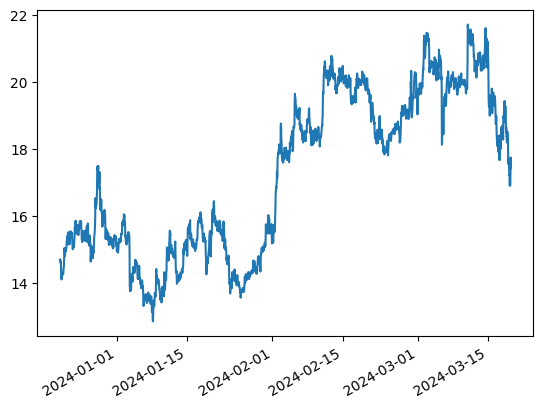

In [6]:
ts = portfolio_ts['chainlink']
ts.plot()

In [11]:
initial_prices = []
real_prices = []
final_prices = []
for coin_id,ts in portfolio_ts.items():
    prices = ts.values
    valid_prices = prices[np.where(~np.isnan(prices))]
    initial_prices = valid_prices[0]
    final_prices = valid_prices[-1]
    real_prices.append()
real_prices = torch.vstack(real_prices)
initial_prices = real_prices[:,0]
final_prices = real_prices[:,-1]

In [12]:
_,mu_ml,sigma_square_ml = ml_estimates_of_geometric_brownian_motion_mertonjump(real_prices,initial_prices,final_prices)
S = simulate_geometric_brownian(initial_prices,mu_ml,sigma_square_ml,2160)

In [66]:
all_jump_densities = []
all_jump_means = []
for selected_index in range(S.shape[0]):
    simulated_prices_selected = S[selected_index]
    real_prices_slected = real_prices[selected_index]

    log_returns_simulated = torch.log(simulated_prices_selected[1:]) - torch.log(simulated_prices_selected[:-1])
    log_returns_real = np.log(real_prices_slected[1:]) - np.log(real_prices_slected[:-1])

    lr_simulated_mean = log_returns_simulated.mean()
    lr_simulated_std2 = log_returns_simulated.std()*3
    non_diffusive_lr = log_returns_real[torch.where(log_returns_real.abs() > lr_simulated_std2)]
    number_of_non_diffusive_lr = non_diffusive_lr.size()[0]
    density_jumps = number_of_non_diffusive_lr/log_returns_simulated.size(0)
    jumps_mean = non_diffusive_lr.abs().mean()

    all_jump_means.append(jumps_mean)
    all_jump_densities.append(density_jumps)

all_jump_means = torch.Tensor(all_jump_means)
all_jump_densities = torch.Tensor(all_jump_densities)

In [83]:
real_prices.shape

torch.Size([4, 2160])

In [84]:
number_of_mcmc = 100
number_of_steps = 2160

repeated_mu = mu_ml.repeat_interleave(number_of_mcmc)
repeated_volatility = sigma_square_ml.repeat_interleave(number_of_mcmc)
repeated_initial_prices = initial_prices.repeat_interleave(number_of_mcmc)

number_of_assets = mu_ml.shape[0]
mcmc_simulation = simulate_geometric_brownian(repeated_initial_prices,repeated_mu,repeated_volatility,number_of_steps)
mcmc_simulation = mcmc_simulation.reshape(number_of_assets,number_of_mcmc,number_of_steps)

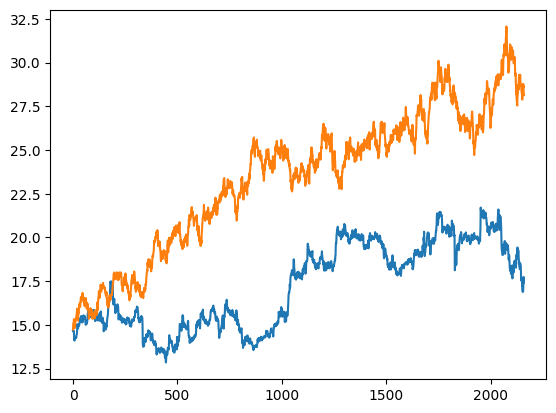

In [92]:
plt.plot(real_prices[1,:])
plt.plot(mcmc_simulation[1,4,:])

In [77]:
# repeated_mu.reshape((number_of_assets,number_of_mcmc))

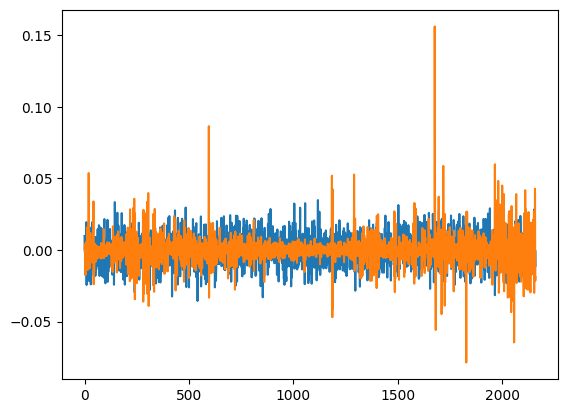

In [65]:
plt.plot(log_returns_simulated.numpy())
plt.plot(log_returns_real)

In [9]:
from torch.distributions import Normal 

def simulate_geometric_brownian(initial_prices,mu_ml,sigma_square_ml,number_of_steps):
    """
    we generate the equation

    \begin{equation}
        S_t = S_0 \exp\left\{(\mu-\frac{\sigma^2}{2})t + \sigma W_t\right\}
    \end{equation}

    :param initial_prices:
    :param mu_ml:
    :param sigma_square_ml:
    :param number_of_steps:
    :return:
    """
    number_of_assets = mu_ml.shape[0]
    sigma_ml = torch.sqrt(sigma_square_ml)
    dW = Normal(0, 1.).sample(sample_shape=(number_of_assets, number_of_steps))
    W = dW.cumsum(axis=1)
    t = torch.arange(0, number_of_steps)[None, :].repeat(number_of_assets, 1)

    S = initial_prices[:, None] * torch.exp((mu_ml - sigma_square_ml * .5)[:, None] * t + sigma_ml[:, None] * W)
    return S

In [10]:
def ml_estimates_of_geometric_brownian_motion_mertonjump(corrected_prices,initial_prices,final_prices):
    """
    Assumes data comes from a merton jump process (No births, all survival times are equal)
    :param data_loader:
    :param skip_end:
    :return:
    """
    # we remove last 4 days in order to compensate for errors in the gathering of the data
    # (many points are missing at the end due to download speed)
    portfolio_survival = corrected_prices.shape[1]
    prices = corrected_prices
    X = torch.log(corrected_prices)

    log_initial_prices = torch.log(initial_prices)
    log_final_prices = torch.log(final_prices)

    dX = log_final_prices - log_initial_prices
    DX = X[:, 1:] - X[:, :-1]
    DX = DX ** 2.
    DX[DX != DX] = 0.
    DX[DX == np.inf] = 0.
    DX[DX == -np.inf] = 0.

    sigma_square_ml = DX.sum(axis=1) / portfolio_survival - (dX ** 2) / portfolio_survival ** 2
    mu_ml = DX.sum(axis=1) / portfolio_survival + 0.5 * sigma_square_ml

    return DX,mu_ml,sigma_square_ml

In [ ]:
def simulate_geometric_brownian(initial_prices,mu_ml,sigma_square_ml,number_of_steps):
    """
    we generate the equation

    \begin{equation}
        S_t = S_0 \exp\left\{(\mu-\frac{\sigma^2}{2})t + \sigma W_t\right\}
    \end{equation}

    :param initial_prices:
    :param mu_ml:
    :param sigma_square_ml:
    :param number_of_steps:
    :return:
    """
    number_of_assets = mu_ml.shape[0]
    sigma_ml = torch.sqrt(sigma_square_ml)
    dW = Normal(0, 1.).sample(sample_shape=(number_of_assets, number_of_steps))
    W = dW.cumsum(axis=1)
    t = torch.arange(0, number_of_steps)[None, :].repeat(number_of_assets, 1)
    S = initial_prices[:, None] * torch.exp((mu_ml - sigma_square_ml * .5)[:, None] * t + sigma_ml[:, None] * W)
    return S